/tmp/ipython-input-1483418658.py:26: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(dest)


✅ BSDS300 loaded
⚠️ Kvasir-SEG skipped


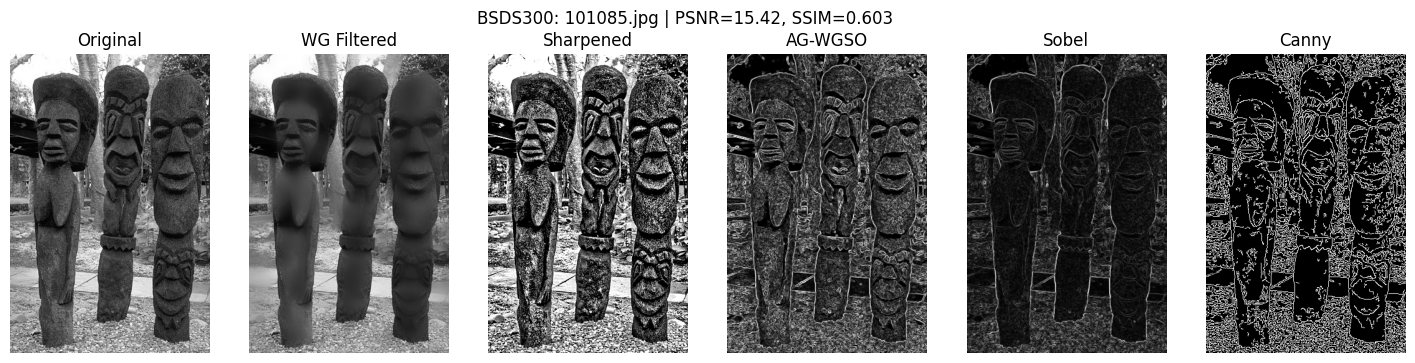

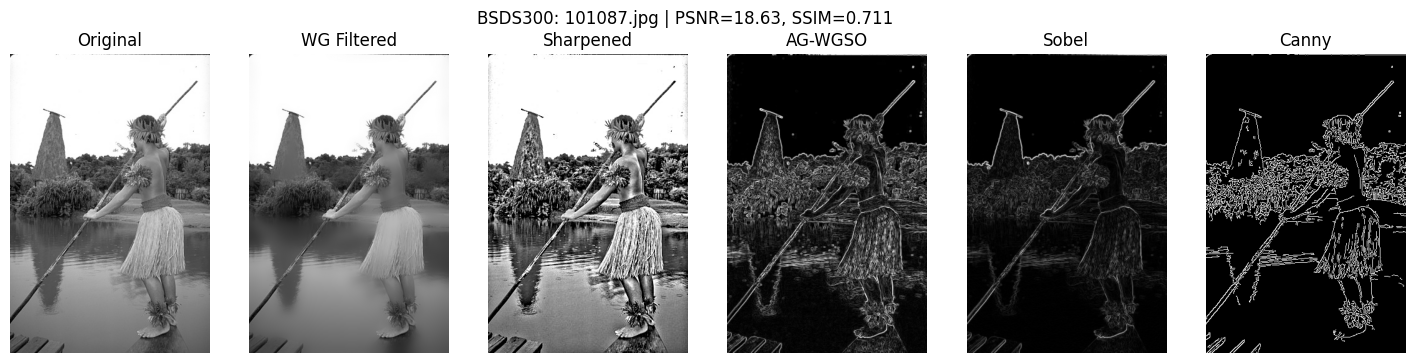

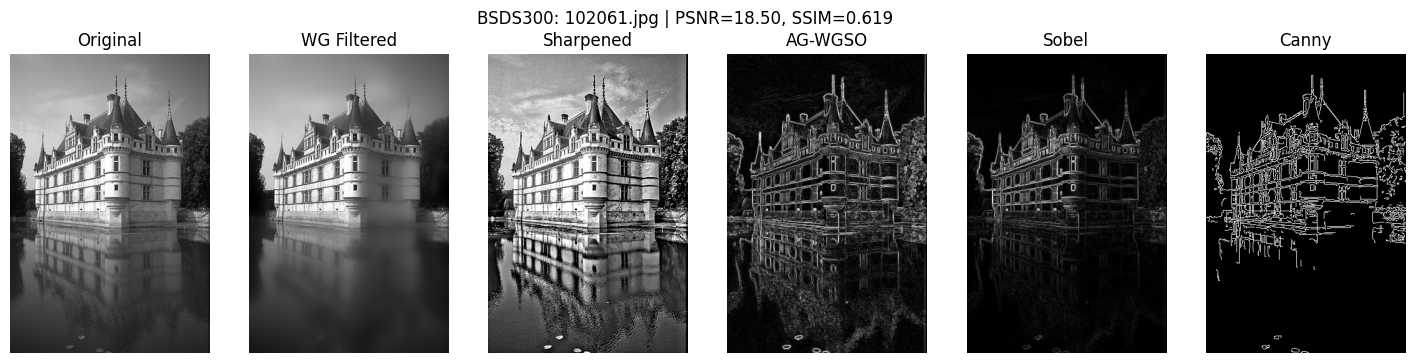

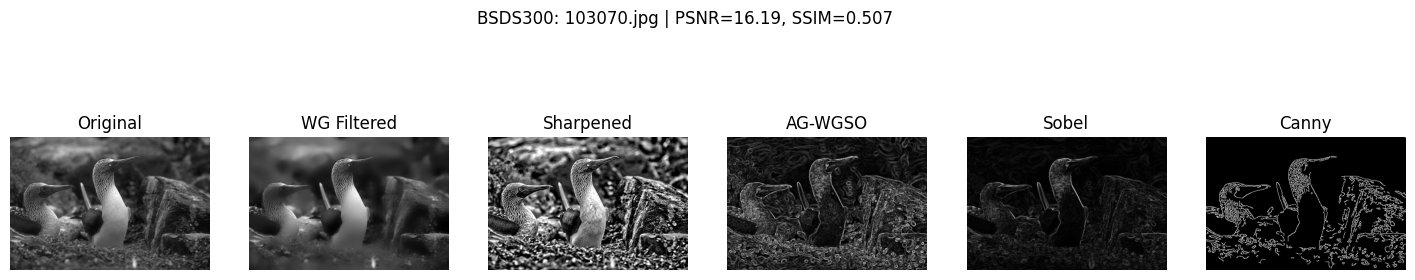

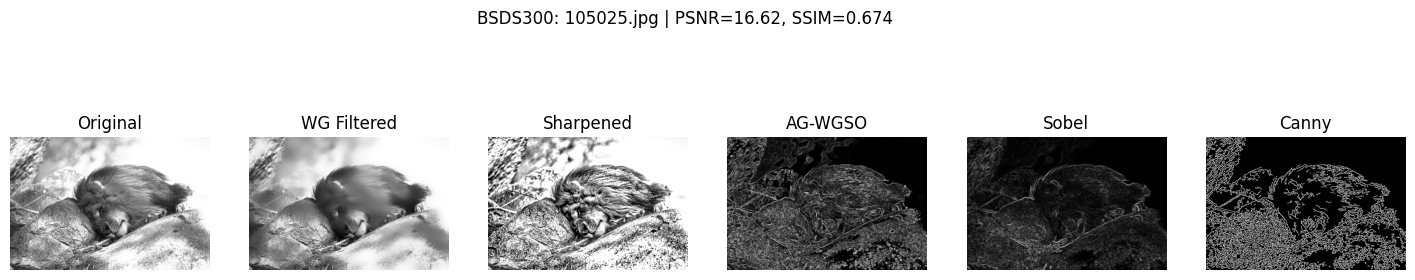


📌 BSDS300 AVG → PSNR=17.07, SSIM=0.623


📌 Kvasir-SEG AVG → PSNR=nan, SSIM=nan

✅ AG-WGSO execution completed successfully


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:


!pip install -q pillow scipy matplotlib scikit-image tqdm opencv-python

# -------------------- Imports --------------------
import os, glob, tarfile, urllib.request, zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from scipy.ndimage import convolve
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# -------------------- Directory Setup --------------------
BASE_DIR = "/content/ag_wgso_experiments"
DATA_DIR = os.path.join(BASE_DIR, "datasets")
os.makedirs(DATA_DIR, exist_ok=True)

# -------------------- Dataset Download --------------------
def fetch_bsds300(dest):
    url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
    archive = os.path.join(dest, "BSDS300.tgz")
    try:
        urllib.request.urlretrieve(url, archive)
        with tarfile.open(archive, "r:*") as tar:
            tar.extractall(dest)
        print("✅ BSDS300 loaded")
    except:
        print("⚠️ BSDS300 failed → Using Lena fallback")
        lena_url = "https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_(test_image).png"
        urllib.request.urlretrieve(lena_url, os.path.join(dest, "lena.png"))

def fetch_kvasir(dest):
    url = "https://datasets.simula.no/downloads/kvasir-seg.zip"
    archive = os.path.join(dest, "kvasir.zip")
    try:
        urllib.request.urlretrieve(url, archive)
        with zipfile.ZipFile(archive, "r") as zf:
            zf.extractall(dest)
        print("✅ Kvasir-SEG loaded")
    except:
        print("⚠️ Kvasir-SEG skipped")

def collect_images(root):
    exts = ("*.png","*.jpg","*.jpeg")
    paths = []
    for e in exts:
        paths += glob.glob(os.path.join(root, "**", e), recursive=True)
    return sorted(paths)

fetch_bsds300(DATA_DIR)
fetch_kvasir(DATA_DIR)

paths_bsds = collect_images(os.path.join(DATA_DIR, "BSDS300"))
paths_kvasir = collect_images(os.path.join(DATA_DIR, "Kvasir-SEG"))

# -------------------- AG-WGSO Core --------------------
def adaptive_gamma_guided_filter(I, r=8, eps=0.01):
    I = I.astype(np.float32)
    I_n = I / 255.0
    kernel = np.ones((2*r+1, 2*r+1), np.float32)
    kernel /= kernel.sum()

    mean_I = cv2.filter2D(I_n, -1, kernel)
    mean_II = cv2.filter2D(I_n * I_n, -1, kernel)
    var_I = np.maximum(mean_II - mean_I**2, 0)

    DR = I_n.max() - I_n.min() + 1e-6
    zeta = (0.001 * DR) ** 2
    gamma = (var_I + zeta) / (np.mean(var_I) + zeta)
    gamma = np.clip(gamma, 0.1, 10)

    a = var_I / (var_I + eps / gamma)
    b = mean_I - a * mean_I

    mean_a = cv2.filter2D(a, -1, kernel)
    mean_b = cv2.filter2D(b, -1, kernel)

    q = mean_a * I_n + mean_b
    return np.clip(q * 255, 0, 255).astype(np.float32)

def sharpen(I, smoothed, chi=5):
    return np.clip(I + chi * (I - smoothed), 0, 255).astype(np.float32)

def sobel_edge(img):
    Gx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], np.float32)
    Gy = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], np.float32)
    gx = convolve(img, Gx, mode="reflect")
    gy = convolve(img, Gy, mode="reflect")
    mag = np.sqrt(gx**2 + gy**2)
    mag = (mag / mag.max()) * 255 if mag.max() > 0 else mag
    return mag.astype(np.uint8)

def canny_edge(img):
    return cv2.Canny(img.astype(np.uint8), 100, 200)

# -------------------- Pipeline --------------------
def ag_wgso_pipeline(img_path):
    img = np.array(Image.open(img_path).convert("L"), dtype=np.float32)
    sm = adaptive_gamma_guided_filter(img)
    sh = sharpen(img, sm, chi=5)

    ag = sobel_edge(sh)
    so = sobel_edge(img)
    ca = canny_edge(img)

    p = psnr(img.astype(np.uint8), sh.astype(np.uint8), data_range=255)
    s = ssim(img.astype(np.uint8), sh.astype(np.uint8), data_range=255)

    return img, sm, sh, ag, so, ca, p, s

# -------------------- Visualization --------------------
def show(res, name):
    img, sm, sh, ag, so, ca, p, s = res
    fig, ax = plt.subplots(1,6, figsize=(18,4))
    titles = ["Original","WG Filtered","Sharpened","AG-WGSO","Sobel","Canny"]
    images = [img, sm, sh, ag, so, ca]
    for i in range(6):
        ax[i].imshow(images[i], cmap='gray')
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    plt.suptitle(f"{name} | PSNR={p:.2f}, SSIM={s:.3f}")
    plt.show()

# -------------------- Run Experiments --------------------
def run(paths, label, n=5):
    ps, ss = [], []
    for pth in paths[:n]:
        res = ag_wgso_pipeline(pth)
        show(res, f"{label}: {os.path.basename(pth)}")
        ps.append(res[-2])
        ss.append(res[-1])
    print(f"\n📌 {label} AVG → PSNR={np.mean(ps):.2f}, SSIM={np.mean(ss):.3f}\n")

run(paths_bsds, "BSDS300")
run(paths_kvasir, "Kvasir-SEG")

print("✅ AG-WGSO execution completed successfully")
